In [143]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [144]:
df = pd.read_csv("../data/k.csv")
df

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
0,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
1,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
2,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
3,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
4,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049
...,...,...,...,...,...,...,...,...
1887,592346,14663,Chi Chi González,COL,29,2021,448,0.125000
1888,642092,19826,Riley Smith,ARI,26,2021,301,0.119601
1889,677976,23798,Randy Dobnak,MIN,26,2021,228,0.118421
1890,433589,4020,Yusmeiro Petit,OAK,36,2021,313,0.118211


In [145]:
tmp = df[["MLBAMID", "PlayerId", "Name"]].drop_duplicates().to_dict("records")

In [146]:
import json

with open("../data/player_ids.json", "w") as fp:
    json.dump(tmp, fp)

In [147]:
from functools import cached_property


class PlayerLookup:
    sources = {
        "mlb": "MLBAMID",
        "fangraphs": "PlayerId",
    }

    @cached_property
    def mapping(self):
        print("loading player ids...")
        with open("../data/player_ids.json", "r") as fp:
            loaded = json.load(fp)
        return pd.DataFrame(loaded)

    def _check_source(self, source):
        source_col = self.sources.get(source)
        assert (
            source_col
        ), f"Unrecognized {source=!r}. Must be one of {list(self.sources)}."
        return source_col

    def get_name(self, player_id, source="mlb"):
        """
        Retrieve player name by id.
        Source can be 'mlb' or 'fangraphs'
        """
        source_col = self._check_source(source)
        filter_ = self.mapping[self.mapping[source_col] == player_id]
        return filter_["Name"].item() if not filter_.empty else filter_

    def get_id(self, player_name, source="mlb"):
        source_col = self._check_source(source)
        filter_ = self.mapping[self.mapping.Name == player_name]
        return filter_[source_col].item() if not filter_.empty else filter_

In [148]:
lookup = PlayerLookup()

In [149]:
test = df[df.Season == 2024]
test

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
0,695243,31757,Mason Miller,OAK,25,2024,249,0.417671
1,621242,14710,Edwin Díaz,NYM,30,2024,216,0.388889
2,518585,7048,Fernando Cruz,CIN,34,2024,288,0.378472
3,623352,14212,Josh Hader,HOU,30,2024,278,0.377698
4,663574,19926,Tony Santillan,CIN,27,2024,122,0.377049
...,...,...,...,...,...,...,...,...
469,641703,16466,Brent Honeywell,- - -,29,2024,149,0.120805
470,621389,14361,Ty Blach,COL,33,2024,330,0.109091
471,657612,16814,Tim Hill,- - -,34,2024,291,0.106529
472,664350,19680,Sixto Sánchez,MIA,25,2024,162,0.104938


In [150]:
train = df[df.Season != 2024]
train

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
474,642585,20666,Félix Bautista,BAL,28,2023,237,0.464135
475,547973,10233,Aroldis Chapman,- - -,35,2023,249,0.413655
476,594798,10954,Jacob deGrom,TEX,35,2023,115,0.391304
477,596112,13594,Robert Stephenson,- - -,30,2023,201,0.383085
478,642207,15816,Devin Williams,MIL,28,2023,231,0.376623
...,...,...,...,...,...,...,...,...
1887,592346,14663,Chi Chi González,COL,29,2021,448,0.125000
1888,642092,19826,Riley Smith,ARI,26,2021,301,0.119601
1889,677976,23798,Randy Dobnak,MIN,26,2021,228,0.118421
1890,433589,4020,Yusmeiro Petit,OAK,36,2021,313,0.118211


In [151]:
seasons = train.groupby(["PlayerId", "Name"])["Season"].apply(list)
k = train.groupby("PlayerId")["K%"].apply(list)
merged = pd.DataFrame(seasons).join(k)
merged

,,Season,K%
PlayerId,Name,,
1246,Matt Bush,[2022],[0.30327869]
1247,Adam Ottavino,"[2023, 2022, 2021]","[0.23754789, 0.30620155, 0.25724638]"
1581,Sean Doolittle,[2021],[0.23766816]
1890,Matt Moore,"[2023, 2022, 2021]","[0.27522936, 0.27302632, 0.18862275]"
1943,Zack Greinke,"[2023, 2022, 2021]","[0.16357504, 0.12478632, 0.17216643]"
...,...,...,...
30134,Tanner Bibee,[2023],[0.24102564]
30279,Bryan Woo,[2023],[0.25067385]
31757,Mason Miller,[2023],[0.27338129]


In [152]:
df.groupby("PlayerId").Season.count().value_counts()

Season
1    319
2    222
4    163
3    159
Name: count, dtype: int64

In [153]:
df["K%"].min()

0.09146341

In [154]:
merged.loc[1943]

,Season,K%
Name,,
Zack Greinke,"[2023, 2022, 2021]","[0.16357504, 0.12478632, 0.17216643]"


In [155]:
train[train.PlayerId == 1247]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
686,493603,1247,Adam Ottavino,NYM,37,2023,261,0.237548
998,493603,1247,Adam Ottavino,NYM,36,2022,258,0.306202
1582,493603,1247,Adam Ottavino,BOS,35,2021,276,0.257246


In [156]:
test[test.PlayerId == 1247]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
63,493603,1247,Adam Ottavino,NYM,38,2024,245,0.285714


In [157]:
def plot_player(player_id, train, test, source="mlb", default_year=2024, default_k=0.3):
    """
    defaults used to show blanks only.
    """
    source_col = lookup._check_source(source)
    train_mask = train[source_col] == player_id
    test_mask = test[source_col] == player_id

    name = train.loc[train_mask, "Name"].unique().item()
    seasons = train.loc[train_mask, "Season"].tolist()
    ks = train.loc[train_mask, "K%"].tolist()

    target_year = (
        test.loc[test_mask, "Season"].item() if test_mask.sum() else default_year
    )
    target = test.loc[test_mask, "K%"].item() if test_mask.sum() else default_k
    alpha = None if test_mask.sum() else 0
    title = f"{name} ({source}: {player_id})"
    if not test_mask.sum():
        title = f"{title}\n NO TARGET DATA FOR {target_year}"

    fig, ax = plt.subplots()
    ax.plot(
        pd.to_datetime(seasons, format="%Y"),
        ks,
        marker="s",
        label="Prev Year(s) K%",
    )
    ax.scatter(
        pd.to_datetime(target_year, format="%Y"),
        target,
        marker="o",
        color="g",
        s=50,
        label=f"{target_year} K% (target)",
        alpha=alpha,
    )
    ax.set_ylim([0, 0.51])
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel("Year")
    ax.set_ylabel("K%")
    ax.set_title(title)
    plt.show();

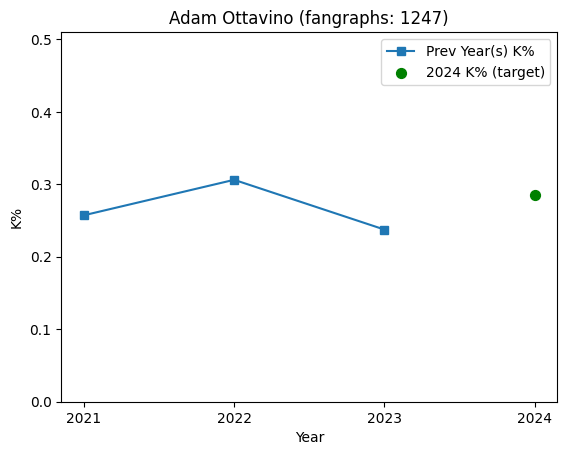

In [158]:
plot_player(1247, train, test, source="fangraphs")

In [159]:
lookup.get_id("Adam Ottavino")

loading player ids...


493603

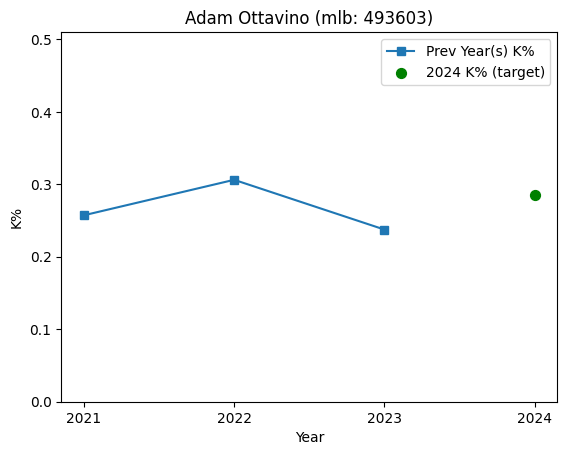

In [160]:
plot_player(lookup.get_id("Adam Ottavino"), train, test)

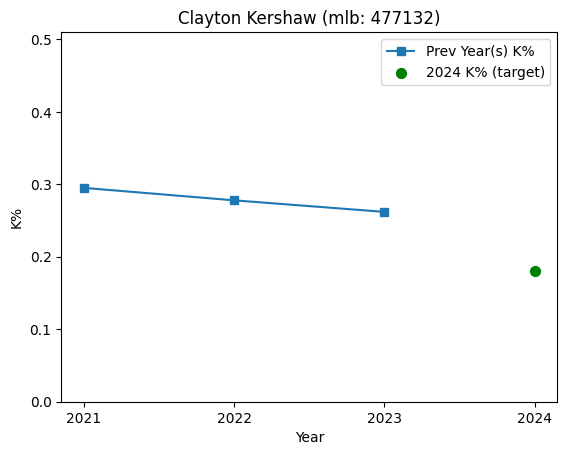

In [161]:
plot_player(lookup.get_id("Clayton Kershaw"), train, test)

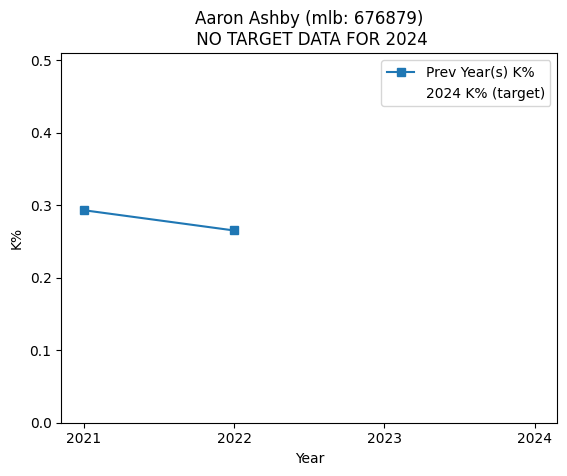

In [162]:
plot_player(lookup.get_id("Aaron Ashby"), train, test)

In [163]:
# players = sorted(train.Name.unique())

# for player in players:
#     plot_player(lookup.get_id(player), train, test)

In [164]:
lookup.mapping[lookup.mapping.Name == "Logan Allen"]

,MLBAMID,PlayerId,Name
383,671106,27589,Logan Allen
838,663531,18555,Logan Allen


In [165]:
df[df.Name == "Logan Allen"]

,MLBAMID,PlayerId,Name,Team,Age,Season,TBF,K%
383,671106,27589,Logan Allen,CLE,25,2024,432,0.182870
744,671106,27589,Logan Allen,CLE,24,2023,537,0.221601
1850,663531,18555,Logan Allen,CLE,24,2021,222,0.166667


In [166]:
# Handle duplicates!
lookup.get_id("Logan Allen")

ValueError: can only convert an array of size 1 to a Python scalar

In [167]:
import requests

In [168]:
def scrape_pithcing_data(year):
    url = f"https://www.baseball-reference.com/leagues/majors/{year}-pitches-pitching.shtml"
    print(f"scraping data from {url}...")

    response = requests.get(url)

    if not response.ok:
        raise Exception(f"Failed to fetch {url}. Status code: {response.status_code}")

    # Normally a BeautifulSoup object can be created here, but baseball ref made this hard to scrape
    # Team data is easy, player data is not
    # Hacky way to get around it for now:
    #     - split text on last table tag seen
    #     - only take up to closing table html tag
    #     - add both back manually
    player_stats = response.text.split("<table")[-1]
    player_stats = player_stats[: player_stats.index("</table>")]
    player_stats = f"<table {player_stats} </table>"

    table = BeautifulSoup(player_stats, "lxml")

    if not table:
        raise Exception(
            "Could not find the 'Player Pitching Pitches' table on the page."
        )

    headers = [header.text for header in table.find("thead").find_all("th")]

    # Exclude the first header if it's a blank column (e.g., rank column)
    if headers[0] == "":
        headers = headers[1:]

    rows = table.find("tbody").find_all("tr", class_=lambda x: x != "thead")

    data = []
    for row in rows:
        cols = row.find_all(["th", "td"])
        cols_text = [col.text.strip() for col in cols]
        data.append(cols_text)

    df = pd.DataFrame(data, columns=headers)
    df = df.assign(Season=year)
    return df

In [169]:
scrape_pithcing_data(2014)

scraping data from https://www.baseball-reference.com/leagues/majors/2014-pitches-pitching.shtml...


,Rk,Name,Age,Tm,IP,PA,Pit,Pit/PA,Str,Str%,...,02h,L/SO,S/SO,L/SO%,3pK,4pW,PAu,Pitu,Stru,Season
0,1,Fernando Abad*,28,OAK,57.1,217,819,3.77,538,66.7%,...,5,13,38,25.5%,7,3,0,0,0,2014
1,2,Alfredo Aceves,31,NYY,19.1,85,323,3.80,219,67.8%,...,1,5,11,31.3%,2,1,0,0,0,2014
2,3,A.J. Achter,25,MIN,11.0,49,169,3.45,106,62.7%,...,0,0,5,0.0%,1,0,0,0,0,2014
3,4,Austin Adams,27,CLE,7.0,30,100,3.33,64,64.0%,...,0,1,3,25.0%,2,0,0,0,0,2014
4,5,Mike Adams,35,PHI,18.2,79,313,3.96,200,64.9%,...,2,10,11,47.6%,4,1,0,0,0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Kirby Yates,27,TBR,36.0,156,690,4.42,439,64.7%,...,4,15,27,35.7%,6,1,0,0,0,2014
796,797,Chris Young,35,SEA,165.0,689,2718,3.94,1731,63.8%,...,12,27,81,25.0%,17,7,0,0,0,2014
797,798,Josh Zeid,27,HOU,20.2,98,382,3.90,237,62.7%,...,2,3,15,16.7%,1,1,0,0,0,2014
798,799,Brad Ziegler,34,ARI,67.0,281,980,3.49,609,63.6%,...,2,11,43,20.4%,5,4,0,0,0,2014


In [172]:
sorted(df.Season.unique())

[2021, 2022, 2023, 2024]

In [173]:
player_stats

' class="sortable stats_table" id="players_pitches_pitching" data-cols-to-freeze=",2" data-non-qual="1" data-qual-text="" data-qual-label="Hide non-qualifiers for rate stats (3.1 PA/G(lgAvg))">\n    <caption>Player Pitching Pitches Table</caption>\n    \n\n   <colgroup><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col><col></colgroup>\n   <thead>      \n      <tr>\n         <th aria-label="Rk" data-stat="ranker" scope="col" class="tooltip ranker poptip sort_default_asc show_partial_when_sorting center" data-tip="&lt;strong&gt;Rank&lt;/strong&gt;&lt;br&gt;This is a count of the rows from top to bottom.&lt;br&gt;It is recalculated following the sorting of a column." >Rk</th>\n         <th aria-label="Name" data-stat="player" scope="col" class=" poptip sort_default_asc show_partial_when_sorting left" data-tip="&lt;strong&gt;Player Name&lt;/strong&gt;&lt;br&gt;&lt;strong&gt;Bo

In [ ]:
results = []
